$\mathbb{MC}$Maps
===
## Arthur E. M. Loureiro - _IFUSP_
Program to estimate the window function using the MCMC Hammer code.

##Important things:
>+ Compile _camb_ without the MPI flag
>+ Change from _"equations"_ to _"equations_ppf"_ in the _Makefile_main_ from _camb_ in order to use $w_a$ for modified gravity


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import numpy as np
import grid3D as gr
import sys
from time import time
from scipy import interpolate
import pylab as pl
from matplotlib import cm
from scipy.sparse import csc_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import vstack
import fkp_class as fkpc
import gauss_pk_class as pkgauss
import os
import emcee
#import triangle
import uuid
from input import *
from selection_function import *

### The *input.py* file contains the intial information

In [3]:
path = os.path.expanduser(camb_path)
#Map_flat = np.loadtxt(map_file)
Map_flat = np.load(map_file)
Map = Map_flat.reshape(n_x,n_y,n_z)

ValueError: total size of new array must be unchanged

###Grids in $k$-space and in real space

Generating the k-space Grid...



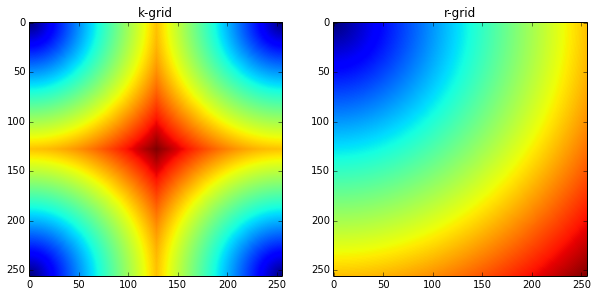

In [4]:
# size of the box
L_x = n_x*cell_size ; L_y = n_y*cell_size ; L_z = n_z*cell_size
# Box's volume
box_vol = L_x*L_y*L_z
L_max = np.sqrt(L_x*L_x + L_y*L_y + L_z*L_z)

print("Generating the k-space Grid...\n")
grid = gr.grid3d(n_x,n_y,n_z,L_x,L_y,L_z)
# multiplying the grid for the cell_size will give us a grid in physical units 
pl.figure(figsize=(10,10))
pl.subplot(2,2,1)
pl.title("k-grid")
pl.imshow(grid.grid_k[2],cmap=cm.jet)
pl.subplot(2,2,2)
pl.title("r-grid")
pl.imshow(grid.grid_r[2],cmap=cm.jet)

### Generating the Bins Matrix $M^a_{ijl}$

In [5]:
%%time
nn = int(np.sqrt(n_x**2 + n_y**2 + n_z**2))
kk_bar = np.fft.fftfreq(nn)
#R Notice that np.fft.fftfreq returns the frequencies (not angular frequencies)
#R for the array with nn entries. By convention, the cell size is d=1 in the way
#R it was written above.
#R Notice also that here nn, kk_bar, etc., are in units of the grid.
#R For any nn>1, the line above always returns 0.5
kmaxbar = np.sqrt(1.7)*np.max(abs(kk_bar))
dk_bar = kmaxbar/(num_bins+0.0001)*np.ones(num_bins)
k_bar = (dk_bar/2)+np.linspace(0.,kmaxbar-dk_bar[2],num_bins)

CPU times: user 265 µs, sys: 88 µs, total: 353 µs
Wall time: 286 µs


## New way Prof. Raul Abramo created to generate the $M_{ijl}^a$ Matrix

In [6]:
%%time
dk0 = 2.0*np.min(kk_bar[np.where(kk_bar > 0)])
#R So, kmaxbar=0.68 is always the maximal frequency, in grid units (cell size=1)
#R But the maximal k should be the either k =~ 0.3 h/Mpc (non-linear scale),
#R or the kmaxbar above (in physical units), whichever is smallest.
if kmaxbar < cell_size*0.3/np.pi/2.0 :
    print('WARNING: max(k) < 0.3 h/Mpc for this grid! May be undersampling...\n')
else:
    print('Can compute P(k) up to k=', 2.0*np.pi*kmaxbar/cell_size, \
          'h/Mpc, but will stop at k=0.3 h/Mpc to save time/memory. \n')
kmaxbar=np.min((kmaxbar,cell_size*0.3/np.pi/2.0))
#R The number of bins should be set by the maximum k to be computed,
#R together with the minimum separation based on the physical volume.
#R Typically, dk =~ 1.4/L , where L is the typical size of the survey.
#R We can use dk =~ 1.5/n_x/(2 pi) (in grid units) to be conservative.
dk0=np.max((dk0,1.5/np.min((n_x,n_y,n_z))/(2.0*np.pi)))
num_bins=np.int(kmaxbar/dk0)
#R This line makes some np variables be printed with less digits
np.set_printoptions(precision=6)
#R Warning about k-binning
print('Will compute spectra up to k =', 2.0*np.pi*kmaxbar/cell_size , \
      'h/Mpc, in', num_bins , 'bins of dk =', 2.0*np.pi*dk0/cell_size, 'h/Mpc\n')

#R We should always use evenly spaced bins
dk_bar = dk0*np.ones(num_bins)
#R OR, use some definition like:
#dk_bar = kmaxbar/(num_bins + 0.0000000001)*np.ones(num_bins)

#R Here are the k's that will be estimated (in grid units):
k_bar = (dk_bar/1.99999) + np.linspace(0.,kmaxbar-dk0,num_bins)
kflat=np.ndarray.flatten(grid.grid_k[:,:,:n_z/2+1])
lenkf=len(kflat)

#R Initialize the sparse matrix MR, using dtype=int8 to keep its size as small as possible.
#R Each row of the matrix corresponds to one k-bin value (k_bar)
#R The columns are the values of the flattened array |k|=|(kx,ky,kz)| .
#R The entries of the MR matrix are: 1 when |k| is inside the bin; 0 if it is not.

#R Initialize first row of the M-matrix
MRline = np.zeros(lenkf,dtype=np.int8)
MRline[ np.where( (kflat > k_bar[0]-dk_bar[0]/2) & (kflat < k_bar[0] + dk_bar[0]/2) ) ] = 1
MRl = coo_matrix([MRline] , dtype=np.int8)
#R Reset the line
MRline = np.zeros(lenkf,dtype=np.int8)

MR = csc_matrix((num_bins,lenkf),dtype=np.int8)
#MR = csr_matrix((num_bins,len(kflat)),dtype=np.int8)


Can compute P(k) up to k= 0.408688932076 h/Mpc, but will stop at k=0.3 h/Mpc to save time/memory. 

Will compute spectra up to k = 0.3 h/Mpc, in 105 bins of dk = 0.00283665250888 h/Mpc

CPU times: user 1.28 s, sys: 50.3 ms, total: 1.33 s
Wall time: 1.39 s


In [7]:
%%time
M = np.asarray([0.5*(np.sign((k_bar[a]+dk_bar[a]/2)-grid.grid_k[:,:,:n_z/2+1])+1.)*0.5*(np.sign(grid.grid_k[:,:,:n_z/2+1]-(k_bar[a]-dk_bar[a]/2))+1.)for a in range(len(k_bar))],dtype=float16)

CPU times: user 3min, sys: 23.1 s, total: 3min 23s
Wall time: 3min 29s


In [8]:
%%time
for a in range(1,num_bins):
    #R Each row of this matrix is all zeros; only becomes non-zero where |k| is inside the bin
    MRline[ np.where( (kflat > k_bar[a]-dk_bar[a]/2.00) & (kflat < k_bar[a] + dk_bar[a]/2.00) ) ] = 1
    MRline[ np.isnan(MRline) ] = 0
    # stack the lines to construct the new M matrix
    MRl = vstack([MRl,coo_matrix(MRline)], dtype=np.int8)
    MRline = np.zeros(lenkf,dtype=np.int8)

# Now convert the matrix to a format which can be used fast in computations
#MR = MRl.tocsr()
MR = MRl.tocsc()

# Delete the initial sparse matrix MRl
MRl = None
del MRl

kbar_counts = MR.dot(np.ones(lenkf))

CPU times: user 28.9 s, sys: 1.69 s, total: 30.6 s
Wall time: 33.8 s


In [9]:
print('Conferindo:')
print('Contagem dos bins usando a *nova* matriz M: ' , MR.dot(np.ones(lenkf))[0:4] )

print('Usando a *velha* matriz M: ',\
      np.sum(np.ndarray.flatten((M[0]))),\
      np.sum(np.ndarray.flatten((M[1]))),\
      np.sum(np.ndarray.flatten((M[2]))),\
      np.sum(np.ndarray.flatten((M[3]))),'\n')

print('Os k_bar originais foram definidos como:', k_bar[0:4] )
tempor = time()
#kav=MR.dot(kflat)/kbar_counts
kav=(MR*kflat)/kbar_counts

print('Com a nova matriz M as medias <k>  sao: ', kav[0:4])
print('Tempo para calcular *todos* os <k> usando a *nova* matriz M:' , time()-tempor )
tempor = time()
print('Com a velha matriz M as medias <k> sao: ',\
      np.sum(np.ndarray.flatten((M[0])*(grid.grid_k[:,:,:n_z/2+1])))/np.sum(np.ndarray.flatten((M[0]))),\
      np.sum(np.ndarray.flatten((M[1])*(grid.grid_k[:,:,:n_z/2+1])))/np.sum(np.ndarray.flatten((M[1]))),\
      np.sum(np.ndarray.flatten((M[2])*(grid.grid_k[:,:,:n_z/2+1])))/np.sum(np.ndarray.flatten((M[2]))),\
      np.sum(np.ndarray.flatten((M[3])*(grid.grid_k[:,:,:n_z/2+1])))/np.sum(np.ndarray.flatten((M[3]))))
print('Tempo para calcular os quatro ks acima com a *velha* matriz M:' , time()-tempor ,'\n')


print('Memoria ocupada pela nova matriz M: ', size(MR))
print('Memoria ocupada pela velha Matriz M: ', size(M))

Conferindo:
Contagem dos bins usando a *nova* matriz M:  [   5.   33.   69.  145.]
Usando a *velha* matriz M:  5.0 33.0 69.0 145.0 

Os k_bar originais foram definidos como: [ 0.002257  0.006805  0.011353  0.0159  ]
Com a nova matriz M as medias <k>  sao:  [ 0.003906  0.007578  0.011734  0.016208]
Tempo para calcular *todos* os <k> usando a *nova* matriz M: 0.0321230888367
Com a velha matriz M as medias <k> sao:  0.00390625 0.00757800655413 0.0117342414186 0.0162077356743
Tempo para calcular os quatro ks acima com a *velha* matriz M: 0.902792215347 

Memoria ocupada pela nova matriz M:  3823745
Memoria ocupada pela velha Matriz M:  887685120


### The fiducial $\bar{n}(\vec{r})=\bar{n}_0e^{-r.b}$ with $\bar{n}_0 = 8 gal/cell$ and $b=0.05$

CPU times: user 416 ms, sys: 32 ms, total: 448 ms
Wall time: 464 ms


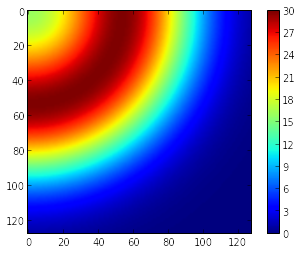

In [6]:
%%time
#n_bar_matrix_fid = selection_func(grid.r_x,grid.r_y,grid.r_z,n_bar0[1],1./16,0.2,1.2)
n_bar_matrix_fid = selection_func(grid.grid_r,30.,62.,38.0)
pl.imshow(n_bar_matrix_fid[:,:,32])
pl.colorbar()

### FKP of the data to get the $\hat{\sigma}_{data}(k)$

In [7]:
%%time
fkp_stuff = fkpc.fkp_init(num_bins,n_bar_matrix_fid,bias,cell_size,n_x,n_y,n_z,M)
FKP1 = fkp_stuff.fkp(Map)
#P_data = fkp_stuff.P_ret.real
Sigma_data = fkp_stuff.sigma.real
#print(P_data)

CPU times: user 6.33 s, sys: 280 ms, total: 6.61 s
Wall time: 6.67 s


pl.imshow(fkp_stuff.nr[1])
pl.colorbar()

Let us difine the **p.d.f.** s and some useful functions:

+ First, the **Gaussian Amplitude** with $\sigma_k = \sqrt{2P(k)V_{box}}$

+ $\mathbb{P}(A_k) = \frac{1}{\sigma_k}exp( -A_k^2/\sigma_k^2)$

+ Random regular phase $\mathbb{P}(\phi_k)$

+ The density constrast in Fourier Space $\delta_k = A_k e^{-i\phi}$

+ The Log-Normal density Field $\delta_{ln} = exp(b\delta_g - b^2\sigma_g/2) -1$

In [8]:
def A_k(P_):									 
	#################################################################################
	# The Gaussian Amplitude
	# Zero Medium and STD=SQRT(2*P(k)*Volume)
	# It must have the 2 factor to take the complex part into account after the iFFT
	#################################################################################
	return np.random.normal(0.0,np.sqrt(2.*P_*box_vol))		
def phi_k(P_): 									     	
	######################
	# Random regular phase
	######################
	return (np.random.random(len(P_)))*2.*np.pi	
def delta_k_g(P_):								     
	########################################	
	# The density contrast in Fourier Space
	########################################
	return A_k(P_)*np.exp(1j*phi_k(P_))	
def delta_x_ln(d_,sigma_,bias_):
	###############################
	# The log-normal density field
	###############################
	return np.exp(bias_*d_ - ((bias_**2)*(sigma_))/2.0) -1.

###The theoretical prediction for the Galaxy Power Spectrum $\hat{P}_{th}(k)$.
### It also estimates $\hat{P}_{data}(k)$ from the data map with the selection function for the Monte Carlo parameters

In [16]:
def P_theory(q,DATA):
	"""
	q = parameters
	DATA = Galaxy Map 
	"""
    ##############################
	# modifing camb and running it
	##############################
	numb = uuid.uuid4()
	powername = "realiz"+str(numb)
	new_file="realiz"+str(numb)+"_params.ini"
	os.system('touch '+new_file)
	params_file = open("params_realiz.ini")
	linhas = params_file.readlines()
	params_file.close()
	temp=linhas
	ct_p = 0
	temp[0] = "output_root = %s\n" %(powername)
	init = time()
	if hubble[0]==True:
		temp[11] = "hubble         = %.4f\n" %(q[ct_p])
		ct_p = ct_p + 1
	if omega_lambda[0] == True:
		temp[17] = "omega_lambda         = %.4f\n" %(q[ct_p])
		ct_p = ct_p + 1
	if omega_cdm[0] == True:
		temp[16] = "omega_cdm      = %.4f\n" %(q[ct_p])
		ct_p = ct_p + 1
	if omega_baryon[0] == True:
		temp[15] = "omega_baryon   = %.4f\n" %(q[ct_p])
		ct_p = ct_p + 1	
	if omega_neutrino[0] == True:
		temp[18] = "omega_neutrino = %.4f\n" %(q[ct_p])
		ct_p = ct_p + 1
	if w[0] == True:
		temp[12] = "w              = %4f\n" %(q[ct_p])
		ct_p = ct_p + 1
	if w_a[0] == True:
		temp[13] = "wa              = %4f\n" %(q[ct_p])
		ct_p = ct_p + 1
	if n_s[0] == True:
		temp[31] = "scalar_spectral_index(1)           = %4f\n" %(q[ct_p])
		ct_p = ct_p + 1
	if tau[0] == True:
		temp[40] = "re_optical_depth           = %4f\n" %(q[ct_p])
		ct_p = ct_p + 1
	################################
	# selection function parameters
	################################
	if n_bar0[0] == True:
		a = q[ct_p]
		ct_p = ct_p + 1
	else:
		a = n_bar0[1]

	if bb[0] == True:
		b = q[ct_p]
		ct_p=ct_p+1
	else:
		b = bb[1]

	if c2[0]==True:
		cc2 = q[ct_p]
		ct_p=ct_p+1
	else:
		cc2=c2[1]
		
	if k0[0] == True:
		kk0 = q[ct_p]
		ct_p=ct_p+1
	else:
		kk0 = k0[1]
	
	final = time()
	tempo = final - init
	#print("time final P Theory=  ", tempo)
	out=open(new_file, 'w')
	wtimein = time()
	for i in temp:
		out.write(i)
	out.close()
	wtimef = time()
	wtimet = wtimef - wtimein
	#print("Tempo para escrever arquivo do camb: ", wtimet)
	tcambi = time()
	os.system(path+"/camb " + new_file + " 1>o.txt 2>e.txt")
	tcambf = time()
	tcambtotal = tcambf - tcambi
	#print("Tempo para rodar o CAMB = ", tcambtotal)
	#############################
	# Reading new camb file
	#############################
	filepower = powername+"_matterpower.dat"
	k_camb, Pk_camb = np.loadtxt(filepower, unpack=1)
	Pk_camb[np.where(Pk_camb<1E-10)]=1.
	final = time()
	#print("tempo camb="+str(final-init))
	#################################
	# Calculating the P_Gauss(k) grid
	#################################
	pkg = pkgauss.gauss_pk(k_camb,Pk_camb,grid.grid_k,cell_size,L_max)
	k_flat = grid.grid_k.flatten()*(2.*np.pi*n_x/L_x)        #this norm factor is so we can have physical unities
	Pk_flat = pkg.Pk_gauss_interp(k_flat)
	p_matrix = Pk_flat.reshape((n_x,n_y,n_z))
	p_matrix[0][0][0] = 1. 						     # Needs to be 1.
	###########################################
	# Generating the selection function matrix
	###########################################
	#n_bar_matrix = selection_func(grid.grid_r,a,b)
	#n_bar_matrix = selection_func(grid.r_x,grid.r_y,grid.r_z,a,b,cc2,kk0)
	#n_bar_matrix = selection_func(grid.grid_r,b,cc2)
	n_bar_matrix = selection_func(grid.grid_r,a,b,cc2)
	print(q)
	fkp_mcmc = fkpc.fkp_init(num_bins,n_bar_matrix,bias,cell_size,n_x,n_y,n_z, M)
	#fkp_mcmc2 = fkpc.fkp_init(num_bins,n_bar_matrix,bias,cell_size,n_x,n_y,n_z, M)
	FKP_DATA = fkp_mcmc.fkp(DATA)
	P_dat = fkp_mcmc.P_ret.real
	sigma_dat = fkp_mcmc.sigma.real 
	######################################
	# here goes the realization's loop
	######################################
	P_all = np.zeros((num_bins, num_realiz))
	sigma_all = np.zeros((num_bins, num_realiz))
	timeloopi = time()
	if realiz_type == 1:
		#print "Doing both Gaussian + Poissonian realizations... \n"
		for m in range(num_realiz):
				#########################
				# gaussian density field
				#########################
				delta_x_gaus = ((delta_k_g(p_matrix).size)/box_vol)*np.fft.ifftn(delta_k_g(p_matrix))	#the iFFT
				var_gr = np.var(delta_x_gaus.real)
				#var_gi = np.var(delta_x_gaus.imag)
				delta_xr_g = delta_x_gaus.real
				#delta_xi_g = delta_x_gaus.imag
				###########################
				# Log-Normal Density Field
				###########################
				delta_xr = delta_x_ln(delta_xr_g, var_gr,bias)
				#delta_xi = delta_x_ln(delta_xi_g, var_gi,bias)
				#######################
				#poissonian realization
				#######################
				N_r = np.random.poisson(n_bar_matrix*(1.+delta_xr))#*(cell_size**3.))			     # This is the final galaxy Map
				#N_i = np.random.poisson(n_bar_matrix*(1.+delta_xi))#*(cell_size**3.))
				##########################################
				#                  FKP                   #
				##########################################
				#print m
				FKP2 = fkp_mcmc.fkp(N_r)
				P = fkp_mcmc.P_ret.real
				sigma = fkp_mcmc.sigma.real
				P_all[:,m] = P
				sigma_all[:,m] = sigma
				#print m
		
		#print "\nDone.\n"
	elif realiz_type == 2:
		#print "Doing Poissonian realizations only \n"
		#########################
		# gaussian density field
		#########################
		delta_x_gaus = ((delta_k_g(p_matrix).size)/box_vol)*np.fft.ifftn(delta_k_g(p_matrix))	#the iFFT
		var_gr = np.var(delta_x_gaus.real)
		#var_gi = np.var(delta_x_gaus.imag)
		delta_xr_g = delta_x_gaus.real
		#delta_xi_g = delta_x_gaus.imag
		###########################
		# Log-Normal Density Field
		###########################
		delta_xr = delta_x_ln(delta_xr_g, var_gr,bias)
		#delta_xi = delta_x_ln(delta_xi_g, var_gi,bias)
		for m in range(num_realiz):
                
				N_r = np.random.poisson(n_bar_matrix*(1.+delta_xr))#*(cell_size**3.))			     # This is the final galaxy Map
				#N_i = np.random.poisson(n_bar_matrix*(1.+delta_xi))#*(cell_size**3.))
                
				FKP2 = fkp_mcmc.fkp(N_r)
                
				P = fkp_mcmc.P_ret.real
				sigma = fkp_mcmc.sigma.real
				P_all[:,m] = P
				sigma_all[:,m] = sigma
        		#print "\nDone.\n" 
	else:
		print("Error, invalid option for realization's type \n")
		sys.exit(-1)
	timeloopf = time()
	timeloopt = timeloopf - timeloopi
	#print("Tempo dos Loops = ", timeloopt)
	P_av = P#(1./num_realiz)*np.sum(P_all, axis=1)
	P_sig = np.sqrt((1./num_realiz)*(np.sum(P_all**2, axis=1))-P_av**2)
	#P_sig =1.
	P_avsig = sigma#(1./num_realiz)*np.sum(sigma_all, axis=1)
	#os.system('rm ' + powername +"*")
	return P_av.real, P_sig.real, P_avsig.real, P_dat 

### Bayesian Functions:
- $\ln$ of a Gaussian

In [17]:
def ln_gaussian(mean, des,x):
    """
    mean, standard deviation and the value
    """
    return -0.5*((x-mean)/des)**2

- $\ln$ of the Prior: flat

$\ln \theta(q_{min} - q)\theta(q-q_{max})$

In [18]:
def ln_prior(q):
	cc = 0
	pH,pLamb,pCDM,pBaryon,pNu,pW,pWa,pN_s,pTau,pN_bar,pBB,pC2,pk0=0,0,0,0,0,0,0,0,0,0,0,0,0
	if hubble[0]==True:
		if 40. < q[cc] < 95.:
			#pH = ln_gaussian(hubble[1],hubble[2],q[cc])
			pH=0.0
		else: 
			return -np.inf
		cc = cc + 1
	if omega_lambda[0]==True:
		if  0.0 < q[cc] < 1.:
			#pLamb = ln_gaussian(omega_lambda[1],omega_lambda[2],q[cc])
			pLamb = 0.0
		else: 
			return -np.inf
		cc = cc + 1
	if omega_cdm[0]==True:
		if  0.05 < q[cc] < 0.6:
			#pCDM = ln_gaussian(omega_cdm[1],omega_cdm[2],q[cc])
			pCDM = 0.0
		else: 
			return -np.inf
		cc = cc + 1
	if omega_baryon[0]==True:
		if  0.006 < q[cc] < 0.1:
			#pBaryon = ln_gaussian(omega_baryon[1],omega_baryon[2],q[cc])
			pBaryon = 0.0
		else: 
			return -np.inf
		cc = cc + 1
	if omega_neutrino[0]==True:
		if  0. < q[cc] < 0.02:
			#pNu = ln_gaussian(omega_neutrino[1],omega_neutrino[2],q[cc])
			pNu = 0.0
		else: 
			return -np.inf
		cc = cc + 1
	if w[0]==True:
		if  -2.0 < q[cc] < -0.4533:
			#pW = ln_gaussian(w[1],w[2],q[cc])
			pW=0.0
		else: 
			return -np.inf
		cc = cc + 1
	if w_a[0]==True:
		if -1.0 < q[cc] < 0.75:
			pWa = 0.0
		else:
			return -np.inf
		cc = cc + 1
	if n_s[0]==True:
		if  0.80 < q[cc] < 1.20:
			#pN_s = ln_gaussian(n_s[1],n_s[2],q[cc])
			pN_s =0.0
		else: 
			return -np.inf
		cc = cc + 1
	if tau[0]==True:
		if  0.04 < q[cc] < 0.2:
			#pTau = ln_gaussian(tau[1],tau[2],q[cc])
			pTau = 0.0
		else: 
			return -np.inf
		cc = cc + 1
	################################
	# Selection function Parameters
	################################
	if n_bar0[0]==True:
		if 20. < q[cc] < 40.:
			#pN_bar = ln_gaussian(n_bar0[1],n_bar0[2],q[cc])			
			pN_bar = 0.0
		else:
			return -np.inf
		cc = cc +1
	if bb[0]==True:
		#if 1./32 < q[cc] < 1./8:
		if 50.0 < q[cc] < 80.:
			#pBB = ln_gaussian(bb[1],bb[2],q[cc])
			pBB = 0.0
		else:
			return -np.inf
		cc = cc +1
	if c2[0]==True:
		if 20. < q[cc] < 50.:
			pC2 = 0.
		else:
			return -np.inf
		cc = cc + 1
	if k0[0]==True:
		if 1.0 < q[cc] < 1.4:
			pk0 = 0.
		else:
			return -np.inf
		cc = cc +1
	return pH + pLamb + pCDM + pBaryon + pNu + pW + pN_s + pTau + pN_bar + pBB + pC2 + pk0

- $\ln$ of the Likelihood

In [19]:
def ln_likelihood(q,DATA,Sig_data):
	"""
	Defining gaussian likelihood
	"""
	#o_cdm, hubble, a,b = q
	#o_cdm, hubble1, w1, a, b = q
	inicial = time()
	lp = ln_prior(q)
	final2 = time()
	tempo2 = final2 - inicial
	#print("Tempo do Prior = ", tempo2)
	if not np.isfinite(lp):
		return -np.inf
	else:
		ptimei = time()
		theory = P_theory(q,DATA)
        
        P_t = theory[0]
        Sig_t1 = theory[1]
        Sig_t2 = theory[2]
        P_data = theory[3]
        
        ptimef = time()
        ptimet = ptimef - ptimei
        #print("Tempo total do P_theory = ", ptimet)
        varr = Sig_data**2 + 0.0*np.nan_to_num(Sig_t1**2)
        lk = -0.5*np.sum(((P_data-P_t)**2)/(varr+1e-20))*(1./num_bins) 
        return lk

- $\ln$ of the Posterior

In [20]:
def ln_post(q,DATA,Sig_data):
    """
    Posterior to be sampled
    """
    lpost = ln_prior(q) + ln_likelihood(q,DATA,Sig_data)
    #nnaammee = "pk_like"+count+".dat"
    #np.savetxt(nnaammee, np.c_[P_d, ln_likelihood(q,P_d,sig_d)[1],lpost])
    #count=count+1
    return lpost

In [23]:
#%%time
qq=[72.,0.2538,-1.,0.,30.,62.,38.]
#qq=[85.47369467,0.25]
print("prior = ", ln_prior(qq), "\n")
print("like = ", ln_likelihood(qq,Map, Sigma_data), "\n")
#print("post = ", ln_post(qq,Map, Sigma_data), "\n")
#print("P_theory = ", P_theory(qq, Map), "\n")
#pqq=P_theory(qq, Map)

prior =  0.0 

[72.0, 0.2538, -1.0, 0.0, 30.0, 62.0, 38.0]
like =  -3.43150650861 



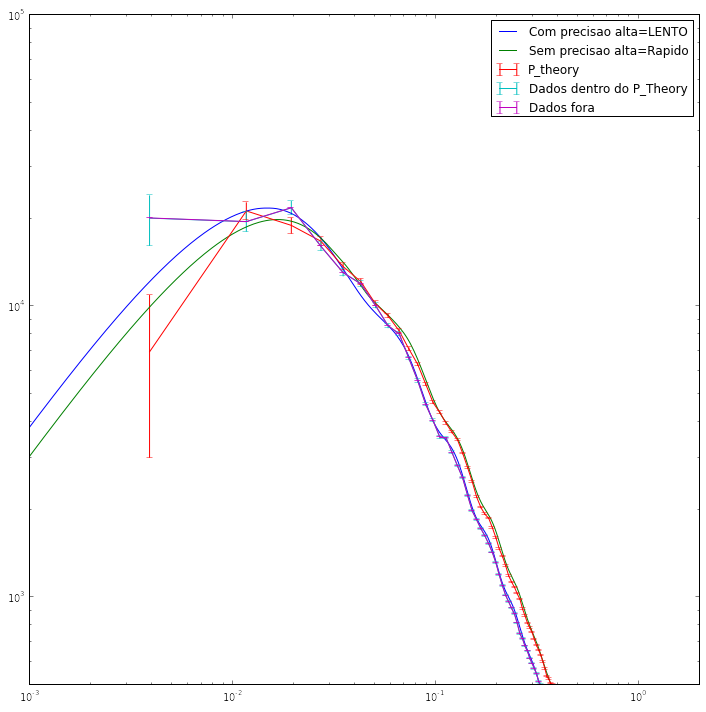

In [53]:
kf,pf = np.loadtxt("z_03_matterpower_estranho.dat", unpack=1)
kf2,pf2 = np.loadtxt("z_03_matterpower.dat", unpack=1)

k1,p1 = np.loadtxt("realiz30371edd-b4e6-4f90-bc74-9bf097e167eb_matterpower.dat", unpack=1)
#Pth = P_theory(qq, Map)
pl.figure(figsize=(12,12))
pl.loglog()
pl.xlim(1E-3,2.0)
pl.ylim(5E2,1E5)
pl.plot(kf[65:],pf[65:],label="Com precisao alta=LENTO")
pl.plot(kf2[65:],pf2[65:],label="Sem precisao alta=Rapido")

#pl.plot(k1[65:],p1[65:])

pl.errorbar(k_bar*(2.*np.pi*n_x/L_x),Pth[0],yerr=Sigma_data,label='P_theory')
pl.errorbar(k_bar*(2.*np.pi*n_x/L_x),Pth[3],yerr=Sigma_data,label='Dados dentro do P_Theory')

pl.errorbar(k_bar*(2.*np.pi*n_x/L_x), fkp_stuff.P_ret.real, yerr=Pth[1],label='Dados fora')
pl.legend()
#pl.plot(k1,p1)

In [16]:
np.mean(Map)

3.3074994087219238

## MCMC using the emcee code
Generating the initial guesses based on the _input.py_ file parameters

In [17]:
med=([])
desv=([])
if hubble[0]==True:
	med.append(hubble[1])
	desv.append(hubble[2])
if omega_lambda[0]==True:
	med.append(omega_lambda[1])
	desv.append(omega_lambda[2])
if omega_cdm[0]==True:
	med.append(omega_cdm[1])
	desv.append(omega_cdm[2])
if omega_baryon[0]==True:
	med.append(omega_baryon[1])
	desv.append(omega_baryon[2])
if omega_neutrino[0]==True:
	med.append(omega_neutrino[1])
	desv.append(omega_neutrino[2])
if w[0]==True:
	med.append(w[1])
	desv.append(w[2])
if w_a[0]==True:
	med.append(w_a[1])
	desv.append(w_a[2])
if n_s[0]==True:
	med.append(n_s[1])
	desv.append(n_s[2])
if tau[0]==True:
	med.append(tau[1])
	desv.append(tau[2])
if n_bar0[0] == True:
	med.append(n_bar0[1])
	desv.append(n_bar0[2])
if bb[0] == True:
	med.append(bb[1])
	desv.append(bb[2])
if c2[0]==True:
	med.append(c2[1])
	desv.append(c2[2])
if k0[0]==True:
	med.append(k0[1])
	desv.append(k0[2])
med = np.array(med) ;  desv = np.array(desv)
starting_guesses = np.zeros((nwalkers,ndim))
#this generates random initial steps 

for i in range(nwalkers):
    starting_guesses[i] = np.random.normal(med,desv)
print(starting_guesses)

[[  6.45950061e+01   1.43079349e-01  -3.48003092e+00   2.12137511e-01
    4.37592608e-02   3.36767494e-01   1.37588758e+00]
 [  5.42394712e+01   2.42344008e-01   1.32029247e+00   1.53743744e-01
    4.43586051e-02   2.05147861e-01   1.57178792e+00]
 [  6.37148922e+01   3.02257726e-01  -1.77044679e+00   2.08689855e-01
    6.24888826e-02   2.51707998e-01   1.02557676e+00]
 [  5.86768125e+01   1.28981458e-01  -1.86309057e+00   1.65790377e-01
    4.53478378e-02   2.53006764e-01   1.52180275e+00]]


In [21]:
%%time
from __future__ import print_function
init = time()
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post, args=[Map, Sigma_data], threads=ncores)
chain_name_file= chain_name + ".dat"
f = open(chain_name_file, "w")
f.close()
#sampler.run_mcmc(starting_guesses, N=nsteps)
for result in sampler.sample(starting_guesses, iterations=nsteps, storechain=True):
	position = np.array(result[0])
	lnlike   = np.array(result[1])
	f = open(chain_name_file, "a")
	for k in range(nwalkers):
		for d in range(ndim):
			print(str(position[k][d]), sep=" ", end=" ", file=f)
		print(lnlike[k], file=f)
        #f.write("{0:4d} {1:s}\n".format(k, " ".join(str(position[k]))))
	f.close()

print("done")
final = time()
print("tempo = "+str(final-init))

SyntaxError: invalid syntax (<ipython-input-21-c53f373f0c46>, line 2)

In [18]:
print("Mean acceptance fraction: {0:.3f}" .format(np.mean(sampler.acceptance_fraction)))
#samples = sampler.flatchain
#like = sampler.flatlnprobability
#np.savetxt(chain_name_file, np.c_[samples, like])
os.system('rm realiz*')
os.system('python post_process_plots.py &')
os.system('echo "Checar os resultados com o post_process_plots.py. Acceptance rate = '+str(np.mean(sampler.acceptance_fraction))+' " | mutt -s "O programa MCMaps terminou de rodar no Cosmos" arthurmloureiro@gmail.com ')

Mean acceptance fraction: 0.268




[ 54.49081867   0.07304094  -0.935179    -0.09410539][ 72.76899124   0.10820394  -0.87163492   0.2103147 ][  6.91685544e+01   2.83168627e-01  -1.27464466e+00   4.89474087e-02][  7.56130375e+01   1.30282991e-01  -8.03027130e-01  -1.99977836e-03]



[  5.65865723e+01   2.78682412e-01  -4.96023586e-01  -3.95893099e-02][  6.10167103e+01   3.42215703e-01  -1.23860487e+00  -1.58974621e-02][  6.60132898e+01   2.37363996e-01  -7.75515910e-01   1.64958483e-02][ 61.70206816   0.30340672  -1.99320722   0.09375572]



[ 77.25909028   0.13855763  -0.73630195   0.33681577][ 59.02154276   0.36555677  -1.4086744    0.18407479][  7.50868554e+01   6.02093228e-02  -8.91061117e-01  -4.84773904e-02][ 58.07988255   0.29264114  -0.94194091   0.08420671]



[  6.85218759e+01   2.41035342e-01  -9.40415293e-01   7.06512889e-04][  7.81233653e+01   1.63256090e-01  -1.60986707e+00   6.01023284e-02][ 77.11411869   0.18921257  -0.97472352   0.08248101][ 60.10862444   0.29358645  -

0





[ 69.48754262   0.3174334   -0.59833757   0.07073603][ 74.72760791   0.23737319  -0.96996759   0.20365747][ 68.45875493   0.16004397  -1.11457498   0.23537337][ 59.28296011   0.18149188  -0.56818209   0.19223571]



[ 65.5885142    0.12404344  -1.85788899   0.10894992][ 75.39738922   0.23513207  -1.64676862   0.15352841][ 66.00296489   0.33807016  -1.35688121   0.27004443][ 55.355914     0.11374055  -1.21321081   0.13479611]



[  6.23619861e+01   3.04341360e-01  -1.58230124e+00   2.69580703e-02][  6.61419057e+01   1.99267479e-01  -1.15153274e+00   4.11181462e-02][ 50.35800113   0.40253665  -1.39777286   0.14719716][ 63.86783802   0.19052838  -1.52216499   0.17600422]



[  6.46925948e+01   3.73596242e-01  -8.95455016e-01  -5.57470240e-03][  6.82950082e+01   1.24530962e-01  -9.45041593e-01   5.16654561e-02][ 81.41863177   0.16944489  -1.66839774   0.12373028][ 61.35746681   0.22193376  -0.90794885   0.13787048]



[ 43.78262384   0.08555097  -1.86768454   0.19706451][ 54.87977149  